# Skin Lesion Classification
## MobileNet V2

In [1]:
import os 
print(os.listdir("/kaggle/input/skin-cancer-mnist-ham10000"))

['hmnist_28_28_L.csv', 'ham10000_images_part_2', 'hmnist_8_8_L.csv', 'ham10000_images_part_1', 'HAM10000_metadata.csv', 'hmnist_28_28_RGB.csv', 'HAM10000_images_part_1', 'hmnist_8_8_RGB.csv', 'HAM10000_images_part_2']


In [2]:
dataPath = "/kaggle/input/skin-cancer-mnist-ham10000/"

### read metadata

In [3]:
import numpy as np
import pandas as pd
df = pd.read_csv(dataPath+'HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


## Data Equilibre 

In [4]:
dx = df['dx'].value_counts().sort_index()
print(dx)

akiec     327
bcc       514
bkl      1099
df        115
mel      1113
nv       6705
vasc      142
Name: dx, dtype: int64


In [5]:
categories = dx.index.values
print(categories)

counts = dx.values
print(counts)

['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
[ 327  514 1099  115 1113 6705  142]


In [6]:
labels = ['Actinic Keratoses', 'Basal Cell Carcinoma', 'Benign Keratosis', 'Dermatofibroma', 'Malignant Melanoma', 'Melanocytic Nevi', 'Vascular Lesions']
#labels = ['光化角化病', '基底細胞癌', '良性角化病', '皮膚纖維瘤', '惡性黑色素瘤', '黑素細胞痣', '血管病變']

num_classes = len(labels) # = len(categories)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style("whitegrid")

def plot_equilibre(categories, counts):

    plt.figure(figsize=(12, 8))

    sns_bar = sns.barplot(x=categories, y=counts)
    sns_bar.set_xticklabels(categories, rotation=45)
    plt.title('Equilibre of Training Dataset')
    plt.show()

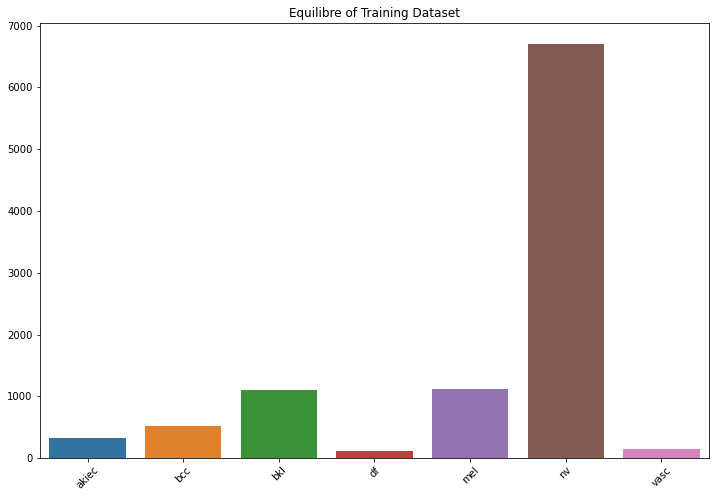

In [8]:
plot_equilibre(categories, counts)

## Copy files from input dataset to local directory

In [9]:
# create local data directory 
data_dir = 'data'
os.mkdir(data_dir)
train_dir = os.path.join(data_dir, 'train')
os.mkdir(train_dir)
val_dir = os.path.join(data_dir, 'val')
os.mkdir(val_dir)
test_dir = os.path.join(data_dir, 'test')
os.mkdir(test_dir)

In [10]:
# create directory for each category in train/val/test directory
for category in categories:
    os.mkdir(os.path.join(train_dir, category))
    os.mkdir(os.path.join(val_dir,   category))
    os.mkdir(os.path.join(test_dir,  category))

In [11]:
!ls data/train
!ls data/val
!ls data/test

akiec  bcc  bkl  df  mel  nv  vasc
akiec  bcc  bkl  df  mel  nv  vasc
akiec  bcc  bkl  df  mel  nv  vasc


In [12]:
from sklearn.model_selection import train_test_split
# Split to train and validation set
df_train, df_tmp = train_test_split(df, test_size=0.2, random_state=101, stratify=df['dx'])
df_val, df_test = train_test_split(df_tmp, test_size=0.5, random_state=101)
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(8012, 7)
(1001, 7)
(1002, 7)


In [13]:
# image_id as df index
df_train = df_train.set_index('image_id') 
df_val   = df_val.set_index('image_id') 
df_test  = df_test.set_index('image_id')

In [14]:
import shutil
folder_1 = os.listdir(dataPath +'ham10000_images_part_1')
folder_2 = os.listdir(dataPath +'ham10000_images_part_2')

def copy_files(df, data_dir):
    fileList = df.index.values
    
    for file in fileList:
        fname = file + '.jpg'
        label = df.loc[file, 'dx'] 

        if fname in folder_1:
            src = os.path.join(dataPath+'ham10000_images_part_1', fname)
            dst = os.path.join(data_dir, label, fname)
            shutil.copyfile(src, dst)
            
        if fname in folder_2:
            src = os.path.join(dataPath+'ham10000_images_part_2', fname)
            dst = os.path.join(data_dir, label, fname)
            shutil.copyfile(src, dst)

In [15]:
copy_files(df_train, train_dir)
copy_files(df_val, val_dir)
copy_files(df_test, test_dir)

## Data Augmentation

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

target_size = (224,224)
batch_size = 16

# Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
#    rotation_range=40,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    shear_range=0.2,
#    zoom_range=0.2,
#    horizontal_flip=True,
#    vertical_flip=True
)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',    
    shuffle=True,
    seed=42,
    class_mode='categorical')

Found 8012 images belonging to 7 classes.


In [17]:
valid_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_datagen.flow_from_directory(
    'data/val',
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=False,    
    class_mode='categorical')

Found 1001 images belonging to 7 classes.


In [18]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=False,    
    class_mode='categorical')

Found 1002 images belonging to 7 classes.


## Build Model

In [19]:
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

In [20]:
base_model=keras.applications.MobileNetV2(input_shape=(224,224,3), weights='imagenet',include_top=False)
#base_model=keras.applications.VGG16(input_shape=(224,224,3), weights='imagenet',include_top=False)
#base_model=keras.applications.InceptionV3(input_shape=(224,224,3), weights='imagenet',include_top=False)
#base_model=keras.applications.ResNet50V2(input_shape=(224,224,3), weights='imagenet',include_top=False)
#base_model=keras.applications.ResNet101V2(input_shape=(224,224,3), weights='imagenet',include_top=False)
#base_model=keras.applications.ResNet151V2(input_shape=(224,224,3), weights='imagenet',include_top=False)
#base_model=keras.applications.DenseNet121(input_shape=(224,224,3), weights='imagenet',include_top=False)
#base_model=keras.applications.DenseNet169(input_shape=(224,224,3), weights='imagenet',include_top=False)
#base_model=keras.applications.DenseNet201(input_shape=(224,224,3), weights='imagenet',include_top=False)
#base_model=keras.applications.NASNetMobile(input_shape=(224,224,3), weights='imagenet',include_top=False)
#base_model=keras.applications.NASNetLarge(input_shape=(224,224,3), weights='imagenet',include_top=False)

9412608/9406464 [==============================] - 0s 0us/step


### add extra layers

In [21]:
# Add Extra Layers to Model
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) 
x=Dense(64,activation='relu')(x) 
out=Dense(num_classes,activation='softmax')(x) #final layer with softmax activation

model=Model(inputs=base_model.input,outputs=out)

In [22]:
## for transfer learning
#base_model.trainable = False 

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [23]:
# Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

## Train Model 

In [31]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST =test_generator.n//test_generator.batch_size

num_epochs = 30

In [25]:
# Add weights to make the model more sensitive to melanoma due to data equilibre
class_weights={
    0: 1.0,  # akiec
    1: 1.0,  # bcc
    2: 1.0,  # bkl
    3: 1.0,  # df
    4: 3.0,  # mel
    5: 1.0,  # nv
    6: 1.0,  # vasc
}

In [32]:
model.fit_generator(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=num_epochs, class_weight=class_weights, validation_data=valid_generator, validation_steps=STEP_SIZE_VALID)

Epoch 1/10
500/500 [==============================] - 112s 223ms/step - loss: 0.2191 - accuracy: 0.9367 - val_loss: 2.3481 - val_accuracy: 0.7258
Epoch 2/10
500/500 [==============================] - 111s 223ms/step - loss: 0.2306 - accuracy: 0.9327 - val_loss: 2.3918 - val_accuracy: 0.7359
Epoch 3/10
500/500 [==============================] - 112s 223ms/step - loss: 0.1935 - accuracy: 0.9446 - val_loss: 3.0360 - val_accuracy: 0.6018
Epoch 4/10
500/500 [==============================] - 111s 221ms/step - loss: 0.2061 - accuracy: 0.9405 - val_loss: 4.8732 - val_accuracy: 0.2198
Epoch 5/10
500/500 [==============================] - 111s 222ms/step - loss: 0.1742 - accuracy: 0.9514 - val_loss: 1.1838 - val_accuracy: 0.7278
Epoch 6/10
500/500 [==============================] - 110s 221ms/step - loss: 0.1854 - accuracy: 0.9482 - val_loss: 1.7505 - val_accuracy: 0.7278
Epoch 7/10
500/500 [==============================] - 111s 222ms/step - loss: 0.1673 - accuracy: 0.9531 - val_loss: 1.5712 -

## Save Model

In [27]:
# Save Model
model.save('tl_skinlesion.h5')

## Evaluate Model

In [28]:
# Evaluate Model
loss, acc = model.evaluate_generator(test_generator, steps=STEP_SIZE_TEST)
print("The accuracy of the model is {:.3f}\nThe Loss in the model is {:.3f}".format(acc,loss))

The accuracy of the model is 0.622
The Loss in the model is 3.039


## Confusion Matrix

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

predY=model.predict_generator(test_generator)
y_pred = np.argmax(predY,axis=1)
#y_label= [labels[k] for k in y_pred]
y_actual = test_generator.classes
cm = confusion_matrix(y_actual, y_pred)
print(cm)

[[  0   9   0   0  26   2   0]
 [  0  29   0   0  14   6   2]
 [  0   1   8   0  85  13   3]
 [  0   1   1   0   8   3   0]
 [  0   0   1   0 101   6   0]
 [  0   4   1   0 180 477   9]
 [  0   0   0   0   0   3   9]]


## classification report

In [30]:
print(classification_report(y_actual, y_pred, target_names=labels))

                      precision    recall  f1-score   support

   Actinic Keratoses       0.00      0.00      0.00        37
Basal Cell Carcinoma       0.66      0.57      0.61        51
    Benign Keratosis       0.73      0.07      0.13       110
      Dermatofibroma       0.00      0.00      0.00        13
  Malignant Melanoma       0.24      0.94      0.39       108
    Melanocytic Nevi       0.94      0.71      0.81       671
    Vascular Lesions       0.39      0.75      0.51        12

            accuracy                           0.62      1002
           macro avg       0.42      0.43      0.35      1002
        weighted avg       0.77      0.62      0.63      1002



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
